In [4]:
import pandas as pd
import numpy as np
import os
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import mygene

from IPython.display import display
from scipy import stats
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from pydeseq2.preprocessing import deseq2_norm
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

# Load Data


In [7]:
#load patient metadata
metadata = "hgsoc_tcga_gdc/data_clinical_patient.txt" 
md = pd.read_csv(metadata, sep="\t", header=0)


#Load count data and transpose to get samples as rows
mRNA = "hgsoc_tcga_gdc/data_mrna_seq_read_counts.txt"    
count = pd.read_csv(mRNA, sep="\t")

# Clean dataset to get ready to be merged later


In [10]:
#Changes the column name to PATIENT_ID
md.rename(columns={"#Patient Identifier": "PATIENT_ID"}, inplace=True)
    
# Set PATIENT_ID as the index
md.set_index("PATIENT_ID", inplace=True)

In [12]:
count = count.set_index("Entrez_Gene_Id").T

count.index.name = "PATIENT_ID"

print(count.head())

Entrez_Gene_Id    1          10         100        1000       10000      \
PATIENT_ID                                                                
TCGA-04-1331-01A         45          5        373       4343        349   
TCGA-04-1332-01A         11          5        254       5875        886   
TCGA-04-1338-01A         11          7        321        379        275   
TCGA-04-1341-01A          4          1       2163        892        129   
TCGA-04-1343-01A         38          2       1406       1106        432   

Entrez_Gene_Id    100008586  100009613  100009667  100009668  100009669  ...  \
PATIENT_ID                                                               ...   
TCGA-04-1331-01A          0          1          1         46          0  ...   
TCGA-04-1332-01A          0          4          8         27          0  ...   
TCGA-04-1338-01A          0          0          3          5          0  ...   
TCGA-04-1341-01A          0          0          3         19          0  .

# Standarize the files by removing ant extra rows from the metadata and any suffixes from the count


In [15]:
# Remove any extra rows 
md = md[md.index.str.startswith("TCGA")]

# Standardize patient IDs by removing sample suffixes 
count.index = count.index.str.extract(r"(^TCGA-\d{2}-\d{4})")[0]

# Drop any NaN values 
count.dropna(inplace=True)

In [16]:
# remove duplicates 
md = md[~md.index.duplicated(keep="first")]
count = count[~count.index.duplicated(keep="first")]

In [17]:
print("Clinical Data Columns:")
print(md.columns.tolist())

Clinical Data Columns:
['Other Patient ID', 'Patient Primary Tumor Site', 'Disease Type', 'Project Name', 'Project Identifier', 'Sex', 'Race Category', 'Ethnicity Category', "Patient's Vital Status", 'Year of Death', 'Primary Diagnosis', 'Year of Diagnosis', 'FIGO Stage', 'Biopsy Site', 'ICD-10 Classification', 'Diagnosis Age', 'Morphology', 'Prior Treatment', 'Prior Malignancy', 'Project State', 'Overall Survival Status', 'Overall Survival (Months)', 'Disease Free Status', 'Disease Free (Months)']


In [21]:
print(md.shape)

(600, 24)


In [22]:
md.head()

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,ICD-10 Classification,Diagnosis Age,Morphology,Prior Treatment,Prior Malignancy,Project State,Overall Survival Status,Overall Survival (Months),Disease Free Status,Disease Free (Months)
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,C56.9,78,8441/3,False,NaN,released,1:DECEASED,43.88961892247043,1:Recurred/Progressed,15.09024559
TCGA-04-1332,b46263ab-c3ca-4fda-a895-74c7e6e6fe22,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2005,...,C56.9,70,8441/3,False,NaN,released,1:DECEASED,40.9658344283837,NaN,NaN
TCGA-04-1335,ab3dbbbe-eed6-4a35-a505-1815225e86c9,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,Dead,2005,...,C56.9,60,8441/3,False,NaN,released,1:DECEASED,1.8068331143232588,NaN,NaN
TCGA-04-1336,538acb2a-c4ca-4656-a91c-841a42dbf15f,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NaN,Alive,NaN,...,C56.9,55,8441/3,False,NaN,released,0:LIVING,49.11300919842313,0:DiseaseFree,49.1501463
TCGA-04-1337,d1e974e7-dd68-40cc-ad06-2b57d964e5a1,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2005,...,C56.9,78,8441/3,False,NaN,released,1:DECEASED,2.0039421813403417,NaN,NaN


In [23]:
count.head()

Entrez_Gene_Id,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
0,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,45,5,373,4343,349,0,1,1,46,0,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1332,11,5,254,5875,886,0,4,8,27,0,...,883,2552,10126,836,1514,0,9284,478,1,8
TCGA-04-1338,11,7,321,379,275,0,0,3,5,0,...,606,513,8552,732,1904,1,1190,424,1,12
TCGA-04-1341,4,1,2163,892,129,0,0,3,19,0,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1343,38,2,1406,1106,432,0,2,1,30,0,...,1315,2775,9348,664,3036,3,8134,343,0,67


In [25]:
print(md.columns.tolist())

['Other Patient ID', 'Patient Primary Tumor Site', 'Disease Type', 'Project Name', 'Project Identifier', 'Sex', 'Race Category', 'Ethnicity Category', "Patient's Vital Status", 'Year of Death', 'Primary Diagnosis', 'Year of Diagnosis', 'FIGO Stage', 'Biopsy Site', 'ICD-10 Classification', 'Diagnosis Age', 'Morphology', 'Prior Treatment', 'Prior Malignancy', 'Project State', 'Overall Survival Status', 'Overall Survival (Months)', 'Disease Free Status', 'Disease Free (Months)']


In [28]:
#sum all counts per sample
sample_sums = count.sum(axis=0)
print(sample_sums)

Entrez_Gene_Id
1           4434
10          2948
100       245424
1000     1605061
10000     363609
          ...   
9992         606
9993     2790918
9994      368957
9995         648
9997        9932
Length: 40796, dtype: int64


In [29]:
#divide sum by one million to derive scalefactor
scale_factor = sample_sums/1000000
scale_factor

Entrez_Gene_Id
1        0.004434
10       0.002948
100      0.245424
1000     1.605061
10000    0.363609
           ...   
9992     0.000606
9993     2.790918
9994     0.368957
9995     0.000648
9997     0.009932
Length: 40796, dtype: float64

In [30]:
cpm = count.div(scale_factor, axis=1)   #axis=1 is important to divide per sample
cpm


Entrez_Gene_Id,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
0,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,10148.849797,1696.065129,1519.818763,2705.816165,959.822227,NaN,681.198910,927.643785,6617.752841,0.0,...,5352.731432,3762.955551,1789.592799,2916.276033,3262.374550,0.000000,2069.569941,5233.672217,7716.049383,2114.377769
TCGA-04-1332,2480.829950,1696.065129,1034.943608,3660.297023,2436.683360,NaN,2724.795640,7421.150278,3884.333189,0.0,...,1069.819342,1982.465435,2043.231106,1700.144187,761.170453,0.000000,3326.504039,1295.543925,1543.209877,805.477245
TCGA-04-1338,2480.829950,2374.491180,1307.940544,236.128097,756.306912,NaN,0.000000,2782.931354,719.320961,0.0,...,734.213501,398.512840,1725.628325,1488.642996,957.244744,1650.165017,426.383004,1149.185406,1543.209877,1208.215868
TCGA-04-1341,902.119982,339.213026,8813.318991,555.742118,354.776697,NaN,0.000000,2782.931354,2733.419652,0.0,...,2184.466902,2883.586087,1530.909974,1539.484629,1926.052844,3300.330033,2808.394944,1452.743816,7716.049383,1308.900524
TCGA-04-1343,8570.139829,678.426052,5728.861073,689.070384,1188.089404,NaN,1362.397820,927.643785,4315.925766,0.0,...,1593.219066,2155.698112,1886.245741,1350.353756,1526.362943,4950.495050,2914.453237,929.647628,0.000000,6745.871929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2104,5638.249887,1696.065129,2901.101767,1555.704113,3347.001862,NaN,0.000000,2782.931354,719.320961,0.0,...,4871.736778,2404.283120,3580.194500,4173.081186,3216.121128,8250.825083,8099.485546,2114.067493,0.000000,6242.448651
TCGA-61-2109,902.119982,678.426052,1894.680227,589.385699,371.277939,NaN,681.198910,7421.150278,4459.789958,0.0,...,2844.774423,988.902233,2301.913930,3347.413076,3686.699426,9900.990099,3570.868080,3463.818277,3086.419753,2114.377769
TCGA-61-2110,2480.829950,678.426052,1695.025751,3436.629511,8514.640727,NaN,1362.397820,4638.218924,2014.098691,0.0,...,5068.011675,1620.463518,3992.835979,1580.157934,1417.767951,4950.495050,1794.033361,1314.516326,3086.419753,2215.062424


In [32]:
#check that all samples summed expression == 1M
cpm.sum(axis=0)

Entrez_Gene_Id
1        1000000.0
10       1000000.0
100      1000000.0
1000     1000000.0
10000    1000000.0
           ...    
9992     1000000.0
9993     1000000.0
9994     1000000.0
9995     1000000.0
9997     1000000.0
Length: 40796, dtype: float64

In [35]:
#log2(CPM+1), +1 because you can't take log of zeros
count_norm = np.log2(cpm+1)
count_norm

Entrez_Gene_Id,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
0,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,13.309171,10.728826,10.570633,11.402381,9.908126,NaN,9.414049,9.858981,12.692344,0.0,...,12.386329,11.878034,10.806222,11.510406,11.672149,0.000000,11.015812,12.353883,12.913834,11.046700
TCGA-04-1332,11.277189,10.728826,10.016730,11.838139,11.251295,NaN,11.412462,12.857621,11.923823,0.0,...,10.064499,10.953808,10.997343,10.732290,9.573970,0.000000,11.700225,10.340455,10.592653,9.655490
TCGA-04-1338,11.277189,11.214010,10.354184,7.889523,9.564734,NaN,0.000000,11.442908,9.492496,0.0,...,9.522019,8.642098,10.753742,10.540751,9.904250,10.689269,8.739386,10.167651,10.592653,10.239856
TCGA-04-1341,9.818774,8.410295,13.105633,9.120865,8.474828,NaN,0.000000,11.442908,11.417019,0.0,...,11.093726,11.494149,10.581116,10.589169,10.912180,11.688832,11.456044,10.505557,12.913834,10.355242
TCGA-04-1343,13.065271,9.408173,12.484284,9.430600,10.215641,NaN,10.412991,9.858981,12.075789,0.0,...,10.638634,11.074609,10.882067,10.400190,10.576827,12.273648,11.509504,9.862091,0.000000,12.720003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2104,12.461288,10.728826,11.502882,10.604279,11.709085,NaN,0.000000,11.442908,9.492496,0.0,...,12.250517,11.231991,11.806225,12.027243,11.651555,13.010498,12.983793,11.046488,0.000000,12.608127
TCGA-61-2109,9.818774,9.408173,10.888500,9.205514,8.540236,NaN,9.414049,12.857621,12.123084,0.0,...,11.474606,9.951142,11.169245,11.709262,11.848505,13.273503,11.802463,11.758564,11.592186,11.046700
TCGA-61-2110,11.277189,9.408173,10.727942,11.747198,13.055899,NaN,10.412991,12.179666,10.976635,0.0,...,12.307489,10.663081,11.963559,10.626766,10.470423,12.273648,10.809795,10.361413,11.592186,11.113783


# Creating a merged file

In [38]:
merged1 = pd.concat([md, count], axis=1, join="inner")
merged1.to_csv("merged1.csv")

In [39]:
merged1

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1332,b46263ab-c3ca-4fda-a895-74c7e6e6fe22,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2005,...,883,2552,10126,836,1514,0,9284,478,1,8
TCGA-04-1338,31872f6a-d225-4f91-b38d-4505d19e406c,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,606,513,8552,732,1904,1,1190,424,1,12
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1343,b7715ff6-57a6-4513-9447-aa8bc93f16d4,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2002,...,1315,2775,9348,664,3036,3,8134,343,0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2104,05263959-c4f5-4540-b6d2-d8c8a128861f,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NaN,Alive,NaN,...,4021,3095,17743,2052,6397,5,22605,780,0,62
TCGA-61-2109,dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2000,...,2348,1273,11408,1646,7333,6,9966,1278,2,21
TCGA-61-2110,88180134-710f-46ea-9b06-5e5d860d6d9f,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2001,...,4183,2086,19788,777,2820,3,5007,485,2,22
TCGA-61-2111,91a17d40-c8cb-4cce-b306-966382a8fe4a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1567,4364,32806,1040,3597,2,5449,818,1,5


In [40]:
print(merged1.shape)

(370, 40820)


In [43]:
# Drop rows where DFS_MONTHS is NaN 
filtered = merged1.dropna(subset=["Disease Free Status"])

#Remove rows where DFS_STATUS is not avalible 
filtered1 = filtered[filtered["Disease Free Status"] != "[Not Available]"]

filtered1.to_csv("filtered1.csv")

In [44]:
print(filtered1.columns) 

Index([          'Other Patient ID', 'Patient Primary Tumor Site',
                     'Disease Type',               'Project Name',
               'Project Identifier',                        'Sex',
                    'Race Category',         'Ethnicity Category',
           'Patient's Vital Status',              'Year of Death',
       ...
                               9988,                         9989,
                                999,                         9990,
                               9991,                         9992,
                               9993,                         9994,
                               9995,                         9997],
      dtype='object', length=40820)


In [45]:
print(filtered1.shape)

(171, 40820)


In [46]:
stage_counts = filtered1["FIGO Stage"].value_counts().reset_index()
stage_counts.columns = ["FIGO Stage", "Sample Count"]
stage_counts

,FIGO Stage,Sample Count
0,Stage IIIC,129
1,Stage IV,25
2,Stage IIIA,5
3,Stage IIIB,4
4,Stage IIC,4
5,Stage IIB,1
6,Stage IIA,1


In [47]:
print(filtered1.head())

                                  Other Patient ID Patient Primary Tumor Site  \
TCGA-04-1331  6d10d4ee-6331-4bba-93bc-a7b64cc0b22a                      Ovary   
TCGA-04-1341  92badeb5-a50e-4a62-a67e-6a8a59c948ab                      Ovary   
TCGA-04-1365  0484a929-7a7f-4926-8d25-470ddab082ec                      Ovary   
TCGA-04-1514  e9483296-cb91-497a-b955-39a3c3289dac                      Ovary   
TCGA-04-1519  e9b5336e-d724-4e7d-8c81-1147abd0a80d                      Ovary   

                                       Disease Type  \
TCGA-04-1331  Cystic, Mucinous and Serous Neoplasms   
TCGA-04-1341  Cystic, Mucinous and Serous Neoplasms   
TCGA-04-1365  Cystic, Mucinous and Serous Neoplasms   
TCGA-04-1514  Cystic, Mucinous and Serous Neoplasms   
TCGA-04-1519  Cystic, Mucinous and Serous Neoplasms   

                                   Project Name Project Identifier     Sex  \
TCGA-04-1331  Ovarian Serous Cystadenocarcinoma            TCGA-OV  Female   
TCGA-04-1341  Ovarian Sero

In [48]:
filtered1 = filtered1.rename(columns={"Patient ID": "Other Patient ID"})

In [49]:
filtered1.head()

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,2644,5350,15418,1394,7916,1,8169,3051,1,64
TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2008,...,5634,6439,20324,2239,7555,8,5532,2300,15,4
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,2295,1371,17831,972,2489,0,6916,601,1,5


In [50]:
filtered1.index.name = "Patient ID"

In [62]:
filtered1.head()

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,2644,5350,15418,1394,7916,1,8169,3051,1,64
TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2008,...,5634,6439,20324,2239,7555,8,5532,2300,15,4
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,2295,1371,17831,972,2489,0,6916,601,1,5


# Make DFS a binary

In [65]:
def clean_dfs_status(value):
    if value == "1:Recurred/Progressed" :
        return 1.0  # Recurrence/Progression
    else:
        return 0.0 #  Disease-free

filtered1["DFS_STATUS_BINARY"] = filtered1["Disease Free Status"].apply(clean_dfs_status)

In [67]:
filtered1.head()

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9989,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4844,8869,1434,6489,0,5776,1931,5,21,1.0
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,3712,7587,757,3831,2,7838,536,5,13,0.0
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,5350,15418,1394,7916,1,8169,3051,1,64,1.0
TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2008,...,6439,20324,2239,7555,8,5532,2300,15,4,0.0
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,1371,17831,972,2489,0,6916,601,1,5,1.0


In [69]:
filtered1 = filtered1.reset_index()

In [71]:
stage_counts = filtered1["DFS_STATUS_BINARY"].value_counts().reset_index()
stage_counts.columns = ["DFS_STATUS_BINARY", "Sample Count"]
stage_counts

,DFS_STATUS_BINARY,Sample Count
0,1.0,113
1,0.0,58


In [73]:
stage_mapping = {
    'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 'Stage IIC': 'Stage II',
    'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III', 'Stage IIIC': 'Stage III',
    'Stage IV': 'Stage IV'
}

filtered1['FIGO Stage'] = filtered1['FIGO Stage'].replace(stage_mapping)

print(filtered1['FIGO Stage'].unique())  


['Stage III' nan 'Stage IV' 'Stage II']


# Filtering anything less than a year of DFS both in the catagory of progressed or disease free

In [76]:
filtered1["Disease Free (Months)"] = pd.to_numeric(filtered1["Disease Free (Months)"], errors="coerce")

filtered_DFS = filtered1[filtered1["Disease Free (Months)"] >= 12]

In [78]:
filtered_DFS


,Patient ID,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,...,9989,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY
0,TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,4844,8869,1434,6489,0,5776,1931,5,21,1.0
2,TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,5350,15418,1394,7916,1,8169,3051,1,64,1.0
3,TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,6439,20324,2239,7555,8,5532,2300,15,4,0.0
5,TCGA-04-1536,1fe19c6b-71d0-4b07-923b-74ea32210db0,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,BLACK OR AFRICAN AMERICAN,NaN,Dead,...,1632,16166,525,4189,0,6881,939,1,4,1.0
6,TCGA-04-1651,55153632-1673-487a-85c0-f156377db1fc,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,3306,13782,1161,5137,1,9831,1386,4,25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,TCGA-61-2012,20c6be4d-7baf-4ea0-93e2-a5212f2e9b9c,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,1851,18743,1350,4211,2,5296,629,1,17,1.0
166,TCGA-61-2088,242943fe-1fa0-4a12-8f7e-9c6c4af1194d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,1657,7882,2741,2249,7,3019,1626,3,16,1.0
167,TCGA-61-2098,eb7c3b35-7a5e-4621-b31f-9775c51f9a23,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NaN,Alive,...,3886,23690,2624,4140,2,9880,2335,0,10,1.0
168,TCGA-61-2101,5d1a54fe-e0df-4c17-b623-b649a136dc82,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,3462,35431,1579,5261,2,26528,886,1,7,1.0


In [79]:
filtered1["Disease Free (Months)"] = pd.to_numeric(filtered1["Disease Free (Months)"], errors="coerce")

# Separate patients who had recurrence (DFS_STATUS_BINARY == 1.0) with DFS <= 13.8 months
recurrence_short_dfs = filtered1[(filtered1["DFS_STATUS_BINARY"] == 1.0) & (filtered1["Disease Free (Months)"] <= 13.8)]

# Separate patients who remained disease-free (DFS_STATUS_BINARY == 0.0) with DFS >= 13.8 months
disease_free_long_dfs = filtered1[(filtered1["DFS_STATUS_BINARY"] == 0.0) & (filtered1["Disease Free (Months)"] >= 13.8)]

print("Patients with recurrence within 13.8 months:", recurrence_short_dfs.shape)
print("Patients disease-free for 13.8+ months:", disease_free_long_dfs.shape)

Patients with recurrence within 13.8 months: (28, 40822)
Patients disease-free for 13.8+ months: (33, 40822)


In [80]:
filtered_dfs_combined = pd.concat([recurrence_short_dfs, disease_free_long_dfs])
filtered_dfs_combined.reset_index(drop=True, inplace=True)

In [84]:
filtered_dfs_combined

,Patient ID,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,...,9989,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY
0,TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,...,1371,17831,972,2489,0,6916,601,1,5,1.0
1,TCGA-13-0888,6cf9f872-2e59-45cf-bb5e-ebd7fa1b3caf,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,1518,3414,868,1450,0,2168,407,0,7,1.0
2,TCGA-13-0897,79e6e31c-22a1-481c-903b-ab5499cbd450,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,3147,7211,1549,4240,0,3947,303,0,5,1.0
3,TCGA-13-1512,82093ed9-a3c8-4e34-931f-4ec7ae745711,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,2179,9767,1405,2397,2,4540,737,0,13,1.0
4,TCGA-20-0987,34f285ab-6c31-4865-a0a7-a57af3567df0,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,1362,2067,489,1413,0,3431,126,2,20,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,TCGA-31-1951,b0839f46-8c82-4619-be3d-c857a1759463,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,4581,12459,1351,7815,3,6810,871,2,45,0.0
57,TCGA-31-1956,e1158102-06f2-47bb-9fe0-49b57f070755,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,2404,8419,834,4995,2,5666,587,2,36,0.0
58,TCGA-31-1959,186d40cd-624c-4016-a497-b30c892d393c,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,3565,13761,1274,8199,0,7430,979,0,19,0.0
59,TCGA-57-1585,5ed14506-f69a-4da8-9965-72d3270b9f72,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,6525,24033,3059,7884,0,28081,1091,1,30,0.0


In [85]:
filtered_dfs_combined.to_csv("DFSfiltered_combined.csv")

In [86]:
disease_free = filtered_dfs_combined[filtered_dfs_combined["DFS_STATUS_BINARY"] == 0.0].copy()

progressed = filtered_dfs_combined[filtered_dfs_combined["DFS_STATUS_BINARY"] == 1.0].copy()

In [88]:
progressed.head()

,Patient ID,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,...,9989,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY
0,TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,...,1371,17831,972,2489,0,6916,601,1,5,1.0
1,TCGA-13-0888,6cf9f872-2e59-45cf-bb5e-ebd7fa1b3caf,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,1518,3414,868,1450,0,2168,407,0,7,1.0
2,TCGA-13-0897,79e6e31c-22a1-481c-903b-ab5499cbd450,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,3147,7211,1549,4240,0,3947,303,0,5,1.0
3,TCGA-13-1512,82093ed9-a3c8-4e34-931f-4ec7ae745711,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,...,2179,9767,1405,2397,2,4540,737,0,13,1.0
4,TCGA-20-0987,34f285ab-6c31-4865-a0a7-a57af3567df0,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,...,1362,2067,489,1413,0,3431,126,2,20,1.0


In [92]:
disease_free = disease_free.set_index("Patient ID", drop=True)
progressed = progressed.set_index("Patient ID", drop=True)

In [93]:
disease_free.to_csv("disease_free.csv")
progressed.to_csv("progressed.csv")

In [96]:
gene = filtered_dfs_combined.columns[filtered1.columns.get_loc("Disease Free (Months)") + 1:]

gene_expr = filtered_dfs_combined.set_index("Patient ID")[gene].T

In [98]:
gene_expr.index.name = "Gene"

print(gene_expr.head())

Patient ID  TCGA-04-1519  TCGA-13-0888  TCGA-13-0897  TCGA-13-1512  \
Gene                                                                 
1                    5.0           8.0           7.0           7.0   
10                  12.0           2.0           5.0           3.0   
100                393.0         324.0         307.0        1223.0   
1000              4637.0        7078.0         847.0        3863.0   
10000              364.0         243.0         665.0        2183.0   

Patient ID  TCGA-20-0987  TCGA-23-1030  TCGA-23-1118  TCGA-24-1417  \
Gene                                                                 
1                    4.0           9.0          20.0          25.0   
10                  11.0           1.0           3.0           0.0   
100                400.0         610.0         399.0         962.0   
1000                24.0        5114.0        1131.0        2965.0   
10000               39.0         197.0         194.0         614.0   

Patient ID  TCGA-2

In [99]:
print(gene_expr.head())

Patient ID  TCGA-04-1519  TCGA-13-0888  TCGA-13-0897  TCGA-13-1512  \
Gene                                                                 
1                    5.0           8.0           7.0           7.0   
10                  12.0           2.0           5.0           3.0   
100                393.0         324.0         307.0        1223.0   
1000              4637.0        7078.0         847.0        3863.0   
10000              364.0         243.0         665.0        2183.0   

Patient ID  TCGA-20-0987  TCGA-23-1030  TCGA-23-1118  TCGA-24-1417  \
Gene                                                                 
1                    4.0           9.0          20.0          25.0   
10                  11.0           1.0           3.0           0.0   
100                400.0         610.0         399.0         962.0   
1000                24.0        5114.0        1131.0        2965.0   
10000               39.0         197.0         194.0         614.0   

Patient ID  TCGA-2

In [102]:
print(gene_expr.shape)
expr_filt = gene_expr.loc[sample_sums.index]
print(expr_filt.shape)
expr_filt.index.name = "Gene"
expr_filt

(40797, 61)
(40796, 61)


Patient ID,TCGA-04-1519,TCGA-13-0888,TCGA-13-0897,TCGA-13-1512,TCGA-20-0987,TCGA-23-1030,TCGA-23-1118,TCGA-24-1417,TCGA-24-1603,TCGA-24-1616,...,TCGA-29-1778,TCGA-30-1714,TCGA-30-1853,TCGA-30-1892,TCGA-31-1950,TCGA-31-1951,TCGA-31-1956,TCGA-31-1959,TCGA-57-1585,TCGA-61-1737
Gene,,,,,,,,,,,,,,,,,,,,,
1,5.0,8.0,7.0,7.0,4.0,9.0,20.0,25.0,8.0,0.0,...,13.0,0.0,7.0,7.0,3.0,15.0,4.0,12.0,19.0,20.0
10,12.0,2.0,5.0,3.0,11.0,1.0,3.0,0.0,6.0,5.0,...,0.0,34.0,0.0,4.0,0.0,5.0,2.0,55.0,9.0,8.0
100,393.0,324.0,307.0,1223.0,400.0,610.0,399.0,962.0,423.0,1044.0,...,617.0,99.0,179.0,205.0,1423.0,349.0,446.0,474.0,602.0,746.0
1000,4637.0,7078.0,847.0,3863.0,24.0,5114.0,1131.0,2965.0,23307.0,6995.0,...,2923.0,241.0,4117.0,1229.0,258.0,9460.0,2953.0,1000.0,4113.0,796.0
10000,364.0,243.0,665.0,2183.0,39.0,197.0,194.0,614.0,3150.0,235.0,...,356.0,80.0,31.0,1073.0,148.0,734.0,1438.0,1100.0,2703.0,846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,...,3.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0
9993,6916.0,2168.0,3947.0,4540.0,3431.0,4302.0,4163.0,6872.0,9496.0,7691.0,...,5811.0,1143.0,3328.0,2110.0,10163.0,6810.0,5666.0,7430.0,28081.0,9965.0
9994,601.0,407.0,303.0,737.0,126.0,394.0,528.0,911.0,2775.0,931.0,...,1027.0,629.0,232.0,331.0,1515.0,871.0,587.0,979.0,1091.0,1073.0


In [104]:
expr_filt_T = expr_filt.T
expr_filt_T

Gene,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1519,5.0,12.0,393.0,4637.0,364.0,0.0,10.0,1.0,22.0,0.0,...,2295.0,1371.0,17831.0,972.0,2489.0,0.0,6916.0,601.0,1.0,5.0
TCGA-13-0888,8.0,2.0,324.0,7078.0,243.0,0.0,1.0,1.0,11.0,0.0,...,1194.0,1518.0,3414.0,868.0,1450.0,0.0,2168.0,407.0,0.0,7.0
TCGA-13-0897,7.0,5.0,307.0,847.0,665.0,0.0,41.0,0.0,2.0,0.0,...,520.0,3147.0,7211.0,1549.0,4240.0,0.0,3947.0,303.0,0.0,5.0
TCGA-13-1512,7.0,3.0,1223.0,3863.0,2183.0,0.0,3.0,1.0,0.0,0.0,...,1720.0,2179.0,9767.0,1405.0,2397.0,2.0,4540.0,737.0,0.0,13.0
TCGA-20-0987,4.0,11.0,400.0,24.0,39.0,0.0,0.0,0.0,1.0,0.0,...,199.0,1362.0,2067.0,489.0,1413.0,0.0,3431.0,126.0,2.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-31-1951,15.0,5.0,349.0,9460.0,734.0,0.0,3.0,4.0,39.0,0.0,...,3609.0,4581.0,12459.0,1351.0,7815.0,3.0,6810.0,871.0,2.0,45.0
TCGA-31-1956,4.0,2.0,446.0,2953.0,1438.0,0.0,1.0,4.0,12.0,0.0,...,1504.0,2404.0,8419.0,834.0,4995.0,2.0,5666.0,587.0,2.0,36.0
TCGA-31-1959,12.0,55.0,474.0,1000.0,1100.0,0.0,0.0,1.0,3.0,0.0,...,1224.0,3565.0,13761.0,1274.0,8199.0,0.0,7430.0,979.0,0.0,19.0


In [106]:
missing_figo_samples = filtered_dfs_combined[filtered_dfs_combined["FIGO Stage"].isna()].index

filtered_dfs_combined = filtered_dfs_combined.drop(missing_figo_samples)
expr_filt_T = expr_filt_T.drop(missing_figo_samples)

In [108]:
print(filtered_dfs_combined['FIGO Stage'].unique()) 

['Stage III' 'Stage IV']


In [110]:
expr_filt_T.to_csv("Expression.csv")

In [112]:
expr_filt_T = expr_filt_T.drop(index="TCGA-57-1994", errors="ignore")


In [114]:
filtered_dfs_combined.index

RangeIndex(start=0, stop=61, step=1)

In [116]:
expr_filt_T.index

Index(['TCGA-04-1519', 'TCGA-13-0888', 'TCGA-13-0897', 'TCGA-13-1512',
       'TCGA-20-0987', 'TCGA-23-1030', 'TCGA-23-1118', 'TCGA-24-1417',
       'TCGA-24-1603', 'TCGA-24-1616', 'TCGA-24-1842', 'TCGA-24-1844',
       'TCGA-24-1928', 'TCGA-24-2020', 'TCGA-24-2271', 'TCGA-24-2297',
       'TCGA-25-1318', 'TCGA-25-2400', 'TCGA-29-1690', 'TCGA-57-1584',
       'TCGA-57-1586', 'TCGA-57-1993', 'TCGA-59-2348', 'TCGA-59-2352',
       'TCGA-61-1738', 'TCGA-61-1918', 'TCGA-61-1919', 'TCGA-61-2111',
       'TCGA-04-1514', 'TCGA-09-0366', 'TCGA-09-1661', 'TCGA-09-1662',
       'TCGA-09-1668', 'TCGA-09-2045', 'TCGA-10-0927', 'TCGA-10-0938',
       'TCGA-13-0797', 'TCGA-13-0800', 'TCGA-13-0905', 'TCGA-13-0920',
       'TCGA-24-1430', 'TCGA-24-1471', 'TCGA-24-1847', 'TCGA-24-2026',
       'TCGA-24-2038', 'TCGA-25-1630', 'TCGA-25-2391', 'TCGA-25-2404',
       'TCGA-25-2409', 'TCGA-29-1703', 'TCGA-29-1774', 'TCGA-29-1778',
       'TCGA-30-1714', 'TCGA-30-1853', 'TCGA-30-1892', 'TCGA-31-1950',
      

In [118]:
!pip install pydeseq2

In [120]:
filtered_dfs_combined = filtered_dfs_combined.set_index("Patient ID")


In [121]:
print("Metadata Index:", filtered_dfs_combined.index)
print("Counts Matrix Index:", expr_filt_T.index)
print("Indexes match?", filtered_dfs_combined.index.equals(expr_filt_T.index))

Metadata Index: Index(['TCGA-04-1519', 'TCGA-13-0888', 'TCGA-13-0897', 'TCGA-13-1512',
       'TCGA-20-0987', 'TCGA-23-1030', 'TCGA-23-1118', 'TCGA-24-1417',
       'TCGA-24-1603', 'TCGA-24-1616', 'TCGA-24-1842', 'TCGA-24-1844',
       'TCGA-24-1928', 'TCGA-24-2020', 'TCGA-24-2271', 'TCGA-24-2297',
       'TCGA-25-1318', 'TCGA-25-2400', 'TCGA-29-1690', 'TCGA-57-1584',
       'TCGA-57-1586', 'TCGA-57-1993', 'TCGA-59-2348', 'TCGA-59-2352',
       'TCGA-61-1738', 'TCGA-61-1918', 'TCGA-61-1919', 'TCGA-61-2111',
       'TCGA-04-1514', 'TCGA-09-0366', 'TCGA-09-1661', 'TCGA-09-1662',
       'TCGA-09-1668', 'TCGA-09-2045', 'TCGA-10-0927', 'TCGA-10-0938',
       'TCGA-13-0797', 'TCGA-13-0800', 'TCGA-13-0905', 'TCGA-13-0920',
       'TCGA-24-1430', 'TCGA-24-1471', 'TCGA-24-1847', 'TCGA-24-2026',
       'TCGA-24-2038', 'TCGA-25-1630', 'TCGA-25-2391', 'TCGA-25-2404',
       'TCGA-25-2409', 'TCGA-29-1703', 'TCGA-29-1774', 'TCGA-29-1778',
       'TCGA-30-1714', 'TCGA-30-1853', 'TCGA-30-1892', 'TCGA-

In [122]:
count.to_csv("count_data_DFS.csv", index=True)  
print("Count data saved successfully!")

Count data saved successfully!


In [125]:
inference = DefaultInference(n_cpus=8)
filtered_dfs_combined.DFS_STATUS_BINARY.astype("category")
dds = DeseqDataSet(
    counts=expr_filt_T,
    metadata=filtered_dfs_combined,
    design_factors="DFS_STATUS_BINARY",   
    refit_cooks=True,
    inference=inference,
)

/Applications/anaconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_92104/1342088967.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


# refit_cooks: 
whether to refit cooks outliers – this is advised, in general.

In [129]:
#run DESeq2 pipeline
dds.deseq2()


Fitting size factors...
... done in 0.06 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.91 seconds.

Fitting dispersion trend curve...
... done in 4.51 seconds.

Fitting MAP dispersions...
... done in 3.37 seconds.

Fitting LFCs...
... done in 1.71 seconds.

Calculating cook's distance...
... done in 0.14 seconds.

Replacing 2517 outlier genes.

Fitting dispersions...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 0.23 seconds.

Fitting LFCs...
... done in 0.18 seconds.



In [131]:
print(filtered_dfs_combined.columns)

Index([          'Other Patient ID', 'Patient Primary Tumor Site',
                     'Disease Type',               'Project Name',
               'Project Identifier',                        'Sex',
                    'Race Category',         'Ethnicity Category',
           'Patient's Vital Status',              'Year of Death',
       ...
                               9989,                          999,
                               9990,                         9991,
                               9992,                         9993,
                               9994,                         9995,
                               9997,          'DFS_STATUS_BINARY'],
      dtype='object', length=40821)


In [133]:
dds

AnnData object with n_obs × n_vars = 61 × 40796
    obs: 'Other Patient ID', 'Patient Primary Tumor Site', 'Disease Type', 'Project Name', 'Project Identifier', 'Sex', 'Race Category', 'Ethnicity Category', "Patient's Vital Status", 'Year of Death', 'Primary Diagnosis', 'Year of Diagnosis', 'FIGO Stage', 'Biopsy Site', 'ICD-10 Classification', 'Diagnosis Age', 'Morphology', 'Prior Treatment', 'Prior Malignancy', 'Project State', 'Overall Survival Status', 'Overall Survival (Months)', 'Disease Free Status', 'Disease Free (Months)', 1, 10, 100, 1000, 10000, 100008586, 100009613, 100009667, 100009668, 100009669, 100009676, 10001, 10002, 10003, 100033392, 100033398, 100033407, 100033409, 100033411, 100033413, 100033414, 100033415, 100033416, 100033417, 100033418, 100033419, 100033420, 100033421, 100033422, 100033423, 100033424, 100033425, 100033426, 100033427, 100033428, 100033429, 100033430, 100033431, 100033432, 100033433, 100033434, 100033435, 100033436, 100033437, 100033438, 100033439,

In [135]:
dds.obsm["size_factors"]

array([0.99831754, 0.45610482, 0.85276229, 0.86556518, 0.35150178,
       0.82167446, 0.91198037, 1.32423718, 1.63435751, 1.27358106,
       1.35620963, 1.45871431, 1.58938978, 1.37533863, 0.58554138,
       1.68653885, 0.9833053 , 1.00197292, 1.21687447, 1.07318332,
       1.02031053, 1.0585191 , 1.30899438, 0.95326749, 0.82296733,
       0.95479555, 0.84406802, 0.77608505, 1.77963275, 2.2552791 ,
       0.49505937, 1.71287389, 1.26172204, 0.54905085, 0.41570073,
       0.60364611, 1.04584469, 0.95787423, 1.65927787, 0.60195164,
       1.25000155, 1.47676532, 1.18102555, 1.19551312, 1.10590868,
       0.89826995, 1.61406325, 1.2841173 , 1.19672399, 1.10891652,
       0.68992868, 1.27303646, 0.45741413, 0.57464638, 0.49757238,
       1.26403274, 1.30829663, 0.77717339, 0.96267662, 1.77426478,
       1.54364891])

In [136]:
print(dds.varm["LFC"])

       Intercept  DFS_STATUS_BINARY
Gene                               
1       1.920889           0.678016
10      2.286209          -0.582078
100     6.134333           0.386067
1000    8.783872          -0.030312
10000   6.909091          -0.319967
...          ...                ...
9992    0.035808          -0.057447
9993    8.838232          -0.060928
9994    6.786213          -0.125561
9995    0.468331          -0.363301
9997    3.137299          -0.041591

[40796 rows x 2 columns]


In [139]:
filtered_dfs_combined.DFS_STATUS_BINARY.astype("category")

Patient ID
TCGA-04-1519    1.0
TCGA-13-0888    1.0
TCGA-13-0897    1.0
TCGA-13-1512    1.0
TCGA-20-0987    1.0
               ... 
TCGA-31-1951    0.0
TCGA-31-1956    0.0
TCGA-31-1959    0.0
TCGA-57-1585    0.0
TCGA-61-1737    0.0
Name: DFS_STATUS_BINARY, Length: 61, dtype: category
Categories (2, float64): [0.0, 1.0]

In [140]:
#differential expression stats
stat_res = DeseqStats(dds, contrast=["DFS_STATUS_BINARY", 1.0, 0.0], inference=inference)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: DFS_STATUS_BINARY 1.0 vs 0.0
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene                                                                      
1         9.775635        0.978171  0.279735  3.496771  0.000471  0.063714
10        7.967465       -0.839761  0.587295 -1.429880  0.152752  0.614950
100     561.382418        0.556976  0.187255  2.974429  0.002935  0.143451
1000   6438.746795       -0.043731  0.502892 -0.086960  0.930704  0.985620
10000   875.369756       -0.461615  0.342930 -1.346092  0.178273  0.647125
...            ...             ...       ...       ...       ...       ...
9992      0.969380       -0.082878  0.518131 -0.159956  0.872916       NaN
9993   6705.504461       -0.087901  0.146255 -0.601013  0.547831  0.879969
9994    837.341513       -0.181146  0.160164 -1.131004  0.258053  0.725187
9995      1.390899       -0.524132  0.598110 -0.876315  0.380859  0.806997
9997     22.598567       -0.06000

... done in 1.12 seconds.



In [141]:
resdf = stat_res.results_df.reset_index()


In [143]:
print(resdf.head())

    Gene     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0      1     9.775635        0.978171  0.279735  3.496771  0.000471  0.063714
1     10     7.967465       -0.839761  0.587295 -1.429880  0.152752  0.614950
2    100   561.382418        0.556976  0.187255  2.974429  0.002935  0.143451
3   1000  6438.746795       -0.043731  0.502892 -0.086960  0.930704  0.985620
4  10000   875.369756       -0.461615  0.342930 -1.346092  0.178273  0.647125


In [145]:
# Count DEGs
significant_DEGs = resdf[resdf['padj'] < 0.05]

num_DEGs = significant_DEGs.shape[0]
print(f"Number of significant DEGs: {num_DEGs}")

# Upregulated and downregulated genes
upregulated = significant_DEGs[significant_DEGs['log2FoldChange'] > 1]
downregulated = significant_DEGs[significant_DEGs['log2FoldChange'] < -1]

print(f"Upregulated genes: {upregulated.shape[0]}")
print(f"Downregulated genes: {downregulated.shape[0]}")

Number of significant DEGs: 175
Upregulated genes: 74
Downregulated genes: 74


In [153]:
# Define significance and fold change thresholds
significance_threshold = 0.05
upregulated_fc_threshold = 1 # log2FoldChange > 1 for upregulated
downregulated_fc_threshold = -1  # log2FoldChange < -1 for downregulated

# significantly upregulated genes
upregulated_genes = resdf[(resdf["padj"] < significance_threshold) & 
                          (resdf["log2FoldChange"] > upregulated_fc_threshold)]
top_upregulated = upregulated_genes.sort_values(by="log2FoldChange", ascending=False)

# significantly downregulated genes
downregulated_genes = resdf[(resdf["padj"] < significance_threshold) & 
                            (resdf["log2FoldChange"] < downregulated_fc_threshold)]
top_downregulated = downregulated_genes.sort_values(by="log2FoldChange", ascending=True)

# Total DEGs (upregulated + downregulated)
total_degs = upregulated_genes.shape[0] + downregulated_genes.shape[0]

print(f"Total DEGs: {total_degs}")
print(f"Upregulated DEGs: {upregulated_genes.shape[0]}")
print(f"Downregulated DEGs: {downregulated_genes.shape[0]}")

print("\nTop Upregulated Genes:")
print(top_upregulated.head(20)) 

print("\nTop Downregulated Genes:")
print(top_downregulated.head(20))  

Total DEGs: 148
Upregulated DEGs: 74
Downregulated DEGs: 74

Top Upregulated Genes:
            Gene      baseMean  log2FoldChange     lfcSE      stat  \
25011     359710    131.272615        4.215215  0.640329  6.582891   
28795       5016   3841.707015        3.764253  0.598670  6.287693   
19835       2290     24.826828        3.755650  0.802200  4.681685   
23290      28907     31.293695        3.752057  0.769139  4.878255   
34240       6492      9.558634        3.713214  0.733760  5.060532   
7656   101927797      2.136597        3.489545  0.924923  3.772796   
20930     257240      9.740120        3.460166  0.624268  5.542754   
23968       3229      7.740435        3.412525  0.733472  4.652561   
17194     138883     19.415608        3.401884  0.780331  4.359541   
33653     645249     21.896668        3.358085  0.721955  4.651374   
23789       3110     44.775334        3.232570  0.621661  5.199896   
25130     360226      5.666847        3.174266  0.513040  6.187167   
33720 

In [154]:
upregulated_gene_list = upregulated["Gene"].tolist()

print(upregulated_gene_list)

['100505839', '100996492', '101927797', '102546229', '105373764', '105378360', '1103', '114794', '122152324', '138883', '149563', '1503', '1556', '157506', '1579', '163732', '196883', '2020', '2290', '23114', '2312', '23217', '23743', '251', '257240', '26', '2624', '26292', '277', '28452', '28882', '28907', '290', '3067', '3110', '3229', '3235', '341947', '346689', '3481', '359710', '360226', '4004', '400892', '401562', '4584', '4693', '4744', '5004', '5005', '5016', '51162', '54456', '54855', '554', '5995', '635', '645249', '645553', '6492', '650368', '6542', '6572', '727897', '762', '79647', '79923', '84879', '84894', '85320', '8761', '9047', '9573', '9848']


In [155]:
downregulated_gene_list = downregulated["Gene"].tolist()

print(downregulated_gene_list)

['100128386', '100130481', '100271300', '100505975', '100506233', '100506371', '100507421', '100874002', '101927700', '101928358', '102467073', '103724390', '10468', '105369652', '105370833', '105379057', '10562', '106479209', '106480169', '106480225', '106480412', '108', '115111', '115409983', '118568816', '118568828', '118827804', '121832806', '128674', '131831', '1373', '137970', '140686', '146053', '150381', '157773', '1618', '162998', '170679', '1843', '201305', '202151', '203569', '2138', '229', '26768', '26864', '27023', '283440', '2893', '2920', '338005', '374462', '387590', '389672', '414760', '441601', '442117', '4606', '494470', '4995', '5100', '51438', '5454', '5455', '55600', '57540', '6372', '645296', '646588', '677819', '8471', '857', '9248']


In [156]:
resdf['neglog10padj'] = -np.log10(resdf.padj)

In [157]:
mg = mygene.MyGeneInfo()

gene_ids = resdf['Gene'].unique().tolist()

gene_info = mg.querymany(gene_ids, scopes="entrezgene", fields="symbol", species="human")

gene_dict = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

resdf['Gene'] = resdf['Gene'].map(gene_dict)

resdf.to_csv("resdf_with_symbols_DFS.csv", index=False)

print("resdf saved with gene symbols as 'resdf_with_symbols_DFS.csv'")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874233', '100874266', '100874283', '100874340', '1009963


resdf saved with gene symbols as 'resdf_with_symbols_DFS.csv'


In [158]:
def Plot_volcano(toplot, xname, yname, nlabel):

    fig,ax=plt.subplots(figsize=(6,6))

    sns.scatterplot(data=toplot, x=xname, y=yname)

    tolabel = toplot.sort_values(yname, ascending=False).head(nlabel)
    for k,row in tolabel.iterrows():
        plt.text(row[xname], row[yname], row['Gene'])

    plt.title("Differential Expression Recurrence vs No Recurrence")
    plt.axhline(-np.log10(0.05), linestyle="--", color="black")
    sns.despine()
    plt.show()

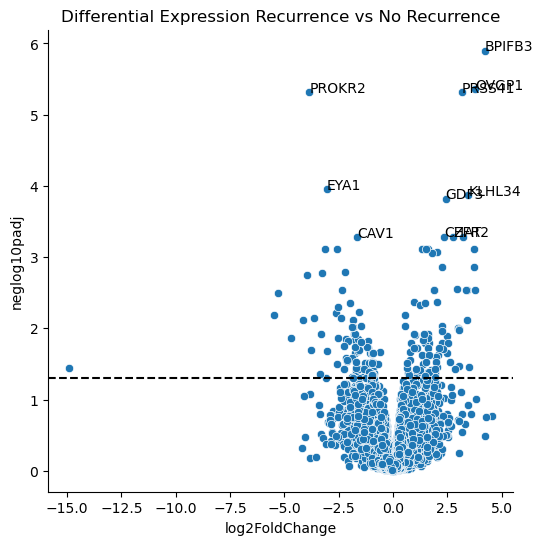

In [159]:
Plot_volcano(resdf, 'log2FoldChange', 'neglog10padj', nlabel=10)

In [160]:
!pip install adjustText

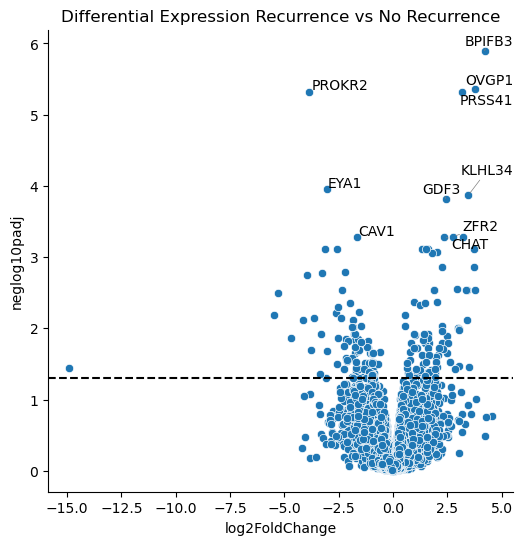

In [161]:
#want the labels not to overlap
def Plot_volcano(toplot, xname, yname, nlabel):
    fig, ax = plt.subplots(figsize=(6,6))

    sns.scatterplot(data=toplot, x=xname, y=yname, ax=ax)

    tolabel = toplot.sort_values(yname, ascending=False).head(nlabel)
    texts = []
    for k, row in tolabel.iterrows():
        texts.append(ax.text(row[xname], row[yname], row['Gene'], fontsize=10))
    min_log2FC = toplot["log2FoldChange"].min()

    filtered_df = toplot[toplot["log2FoldChange"] > min_log2FC]

    # Adjust text to avoid overlap
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.title("Differential Expression Recurrence vs No Recurrence")
    plt.axhline(-np.log10(0.05), linestyle="--", color="black")
    sns.despine()
    plt.show()

Plot_volcano(resdf, 'log2FoldChange', 'neglog10padj', nlabel=10)

In [236]:
#want to get rid of the leftmost point since it's making the graph look weird
def Plot_volcano(toplot, xname, yname, nlabel, filename=None):
    fig, ax = plt.subplots(figsize=(6,6))

    # Filter out extreme log2FoldChange values
    toplot = toplot[(toplot[xname] > -10)]  # Adjust this threshold as needed

    sns.scatterplot(data=toplot, x=xname, y=yname, ax=ax)

    tolabel = toplot.sort_values(yname, ascending=False).head(nlabel)
    texts = []
    for k, row in tolabel.iterrows():
        texts.append(ax.text(row[xname], row[yname], row['Gene'], fontsize=10))

    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))
    
    plt.title("Differential Expression Recurrence vs No Recurrence")
    plt.axhline(-np.log10(0.05), linestyle="--", color="black")
    sns.despine()


File should be saved at: /Users/vidushibansal/Bioinformatics Project/DFS_volcano_plot.png
File exists: True


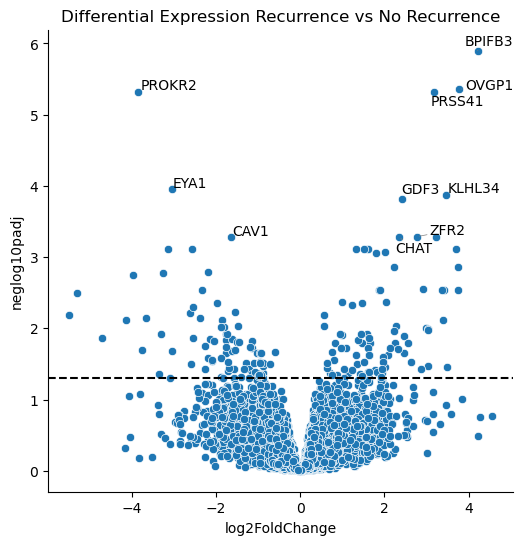

In [238]:
Plot_volcano(resdf, 'log2FoldChange', 'neglog10padj', 
             nlabel=10, filename="DFS_volcano_plot.png")

print("File should be saved at:", os.path.abspath("DFS_volcano_plot.png"))

print("File exists:", os.path.exists("DFS_volcano_plot.png"))

In [184]:
top_genes_deseq = resdf.sort_values('padj').head(20)[['Gene', 'log2FoldChange']]

# Upregulated: log2FC > 0
upregulated_genes_deseq = top_genes_deseq[top_genes_deseq['log2FoldChange'] > 0]

# Downregulated: log2FC < 0
downregulated_genes_deseq = top_genes_deseq[top_genes_deseq['log2FoldChange'] < 0]

print("Upregulated Genes:\n", upregulated_genes_deseq)
print("\nDownregulated Genes:\n", downregulated_genes_deseq)

Upregulated Genes:
           Gene  log2FoldChange
25011   BPIFB3        4.215215
28795    OVGP1        3.764253
25130   PRSS41        3.174266
20930   KLHL34        3.460166
40388     GDF3        2.427479
14659     CHAT        2.342746
20112     ZFR2        2.770545
23789     MNX1        3.232570
37049  AKIRIN1        1.329309
34240     SIM1        3.713214
39219   PABPC4        1.518133
18472   CITED4        1.602363
24712    KLRG2        2.020347
30750    AVPR2        1.802948
19171      EN2        2.235665

Downregulated Genes:
          Gene  log2FoldChange
16761  PROKR2       -3.848906
19345    EYA1       -3.056225
39043    CAV1       -1.647681
30053  POU3F3       -3.134470
28373  MYBPC2       -2.569047


# Heat Map

In [187]:
tmp = resdf.loc[resdf.padj<0.05]
tmp = tmp.sort_values("log2FoldChange")
tmp = pd.concat([tmp.head(10), tmp.tail(10)])
tmp


,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
18390,DAZL,88.616386,-14.894590,3.961033,-3.760279,1.697242e-04,0.036135,1.442066
24181,LINC00221,7.524123,-5.485401,1.242341,-4.415373,1.008359e-05,0.006594,2.180854
19234,PAGE2,71.353235,-5.309085,1.147595,-4.626270,3.723091e-06,0.003195,2.495467
29344,MAGEC2,29.738116,-4.700579,1.132455,-4.150788,3.313321e-05,0.013788,1.860501
39944,GPR50,5.085172,-4.128531,0.947213,-4.358610,1.308910e-05,0.007649,2.116409
28986,PCDH8,18.725126,-3.972637,0.826813,-4.804761,1.549367e-06,0.001773,2.751277
16761,PROKR2,55.250590,-3.848906,0.624431,-6.163864,7.099086e-10,0.000005,5.312078
12045,RNU1-89P,3.946755,-3.750509,0.940708,-3.986901,6.694205e-05,0.020204,1.694563
17152,UNC5D,36.168594,-3.651834,0.831841,-4.390064,1.133176e-05,0.007238,2.140392
27999,SEPTIN7P11,2.410713,-3.345221,0.911795,-3.668829,2.436643e-04,0.043249,1.364020


In [189]:
expr_dds = deseq2_norm(expr_filt_T)[0]
expr_dds

Gene,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1519,5.008426,12.020224,393.662322,4644.814727,364.613448,0.0,10.016853,1.001685,22.037077,0.0,...,2298.867759,1373.310544,17861.050550,973.638110,2493.194707,0.000000,6927.655521,602.012864,1.001685,5.008426
TCGA-13-0888,17.539828,4.384957,710.363033,15518.362800,532.772275,0.0,2.192478,2.192478,24.117263,0.0,...,2617.819325,3328.182358,7485.121588,1903.071335,3179.093820,0.000000,4753.293381,892.338748,0.000000,15.347349
TCGA-13-0897,8.208618,5.863299,360.006539,993.242797,779.818725,0.0,48.079049,0.000000,2.345319,0.0,...,609.783063,3690.360190,8456.049358,1816.449931,4972.077281,0.000000,4628.487979,355.315900,0.000000,5.863299
TCGA-13-1512,8.087201,3.465943,1412.949633,4462.979911,2522.051552,0.0,3.465943,1.155314,0.000000,0.0,...,1987.140939,2517.430294,11283.956716,1623.216872,2769.288855,2.310629,5245.127827,851.466786,0.000000,15.019088
TCGA-20-0987,11.379743,31.294294,1137.974337,68.278460,110.952498,0.0,0.000000,0.000000,2.844936,0.0,...,566.142232,3874.802616,5880.482384,1391.173626,4019.894344,0.000000,9760.974872,358.461916,5.689872,56.898717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-31-1951,11.465290,3.821763,266.759075,7230.776084,561.034846,0.0,2.293058,3.057411,29.809753,0.0,...,2758.548719,3501.499497,9523.069686,1032.640432,5973.415972,2.293058,5205.241557,665.751159,1.528705,34.395869
TCGA-31-1956,5.146857,2.573428,573.874512,3799.666890,1850.294950,0.0,1.286714,5.146857,15.440570,0.0,...,1935.218084,3093.260821,10832.846443,1073.119602,6427.137187,2.573428,7290.522383,755.301207,2.573428,46.321709
TCGA-31-1959,12.465245,57.132373,492.377178,1038.770418,1142.647460,0.0,0.000000,1.038770,3.116311,0.0,...,1271.454992,3703.216542,14294.519729,1323.393513,8516.878661,0.000000,7718.064209,1016.956240,0.000000,19.736638


In [190]:
print(tmp.Gene.head())  
print(expr_dds.columns[:10])  

18390         DAZL
24181    LINC00221
19234        PAGE2
29344       MAGEC2
39944        GPR50
Name: Gene, dtype: object
Index([1, 10, 100, 1000, 10000, 100008586, 100009613, 100009667, 100009668,
       100009669],
      dtype='object', name='Gene')


In [193]:
common_genes = set(tmp["Gene"]) & set(expr_dds.columns)
print(f"Number of matching genes: {len(common_genes)}")

Number of matching genes: 0


In [195]:
expr_dds.columns = expr_dds.columns.astype(str)
tmp["Gene"] = tmp["Gene"].astype(str)

expr_dds.columns = expr_dds.columns.str.strip().str.upper()
tmp["Gene"] = tmp["Gene"].str.strip().str.upper()

common_genes = set(tmp["Gene"]) & set(expr_dds.columns)
print(f"Number of matching genes after formatting: {len(common_genes)}")

Number of matching genes after formatting: 0


In [197]:
mg = mygene.MyGeneInfo()

gene_ids = expr_dds.columns.astype(str).tolist()

gene_info = mg.querymany(gene_ids, scopes="entrezgene", fields="symbol", species="human")

gene_dict = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

expr_dds = expr_dds.rename(columns=gene_dict)

print("Renamed columns in expr_dds:", expr_dds.columns.tolist()[:10])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874233', '100874266', '100874283', '100874340', '1009963


Renamed columns in expr_dds: ['A1BG', 'NAT2', 'ADA', 'CDH2', 'AKT3', 'GAGE12F', 'LINC02584', 'POU5F1P5', 'POU5F1P6', 'POU5F1P7']


In [202]:
from scipy.stats import zscore

expr_dds_log = np.log1p(expr_dds)

expr_dds_scaled = expr_dds_log.apply(zscore, axis=1)

expr_dds_scaled = expr_dds_scaled.fillna(0)

In [204]:
toheat = expr_dds.loc[:, expr_dds.columns.isin(tmp.Gene)]
toheat

toheat = toheat.apply(stats.zscore)
toheat

Gene,MIR548XHG,RNU1-89P,PROKR2,UNC5D,OR1N1,DAZL,PAGE2,FOXG1,KLHL34,IGKV5-2,HOXC13,LINC00221,BPIFB3,SEPTIN7P11,OVGP1,PCDH8,MAGEC2,MNX1-AS1,SIM1,GPR50
Patient ID,,,,,,,,,,,,,,,,,,,,
TCGA-04-1519,-0.224071,-0.305713,-0.276215,-0.283407,-0.192160,-0.130564,-0.186051,-0.244655,0.041383,-0.170280,-0.251624,-0.237057,-0.214243,-0.151582,-0.300401,-0.160691,-0.196905,-0.254939,-0.294484,-0.137189
TCGA-13-0888,-0.224071,4.103273,-0.281315,-0.283407,-0.149197,-0.130564,-0.186051,0.630350,-0.244323,-0.170280,0.952381,-0.237057,-0.209655,-0.168809,-0.350286,-0.153203,-0.196905,-0.280613,-0.226937,-0.155344
TCGA-13-0897,-0.224071,-0.305713,-0.269373,-0.283407,-0.192160,-0.130564,-0.185105,-0.244655,0.178184,-0.158966,2.444060,-0.237057,-0.259137,-0.148641,-0.350784,-0.163970,-0.196905,-0.175417,-0.294484,-0.155344
TCGA-13-1512,-0.136368,-0.237381,-0.263667,-0.283407,-0.192160,-0.123788,-0.186051,-0.244655,-0.203100,-0.168422,-0.222115,-0.237057,-0.242131,-0.148940,-0.352920,-0.143166,-0.196905,-0.191778,1.841101,-0.155344
TCGA-20-0987,-0.094491,-0.305713,-0.281315,-0.283407,-0.192160,-0.126393,-0.131002,-0.244655,-0.315295,0.479327,-0.251624,-0.193897,3.152276,-0.168809,-0.354572,-0.163970,1.168306,-0.025401,-0.206836,-0.155344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-31-1951,-0.224071,-0.305713,-0.191804,-0.229504,-0.191008,-0.130564,-0.184202,-0.105722,-0.290553,-0.169666,-0.183293,-0.237057,-0.259623,-0.168809,-0.346414,-0.163970,-0.195640,0.091613,-0.247387,-0.155344
TCGA-31-1956,-0.204536,-0.305713,-0.235455,-0.192666,-0.192160,-0.130564,-0.185013,-0.244655,-0.231991,0.411124,-0.251624,-0.227297,-0.262848,-0.168809,-0.343458,-0.163970,-0.196905,-0.264123,-0.254842,-0.155344
TCGA-31-1959,-0.224071,-0.305713,-0.207268,-0.275268,-0.192160,-0.130564,-0.186051,-0.236445,-0.315295,-0.163599,1.977085,-0.237057,-0.261753,-0.168809,-0.352967,0.057092,-0.193467,-0.200740,-0.294484,-0.136517


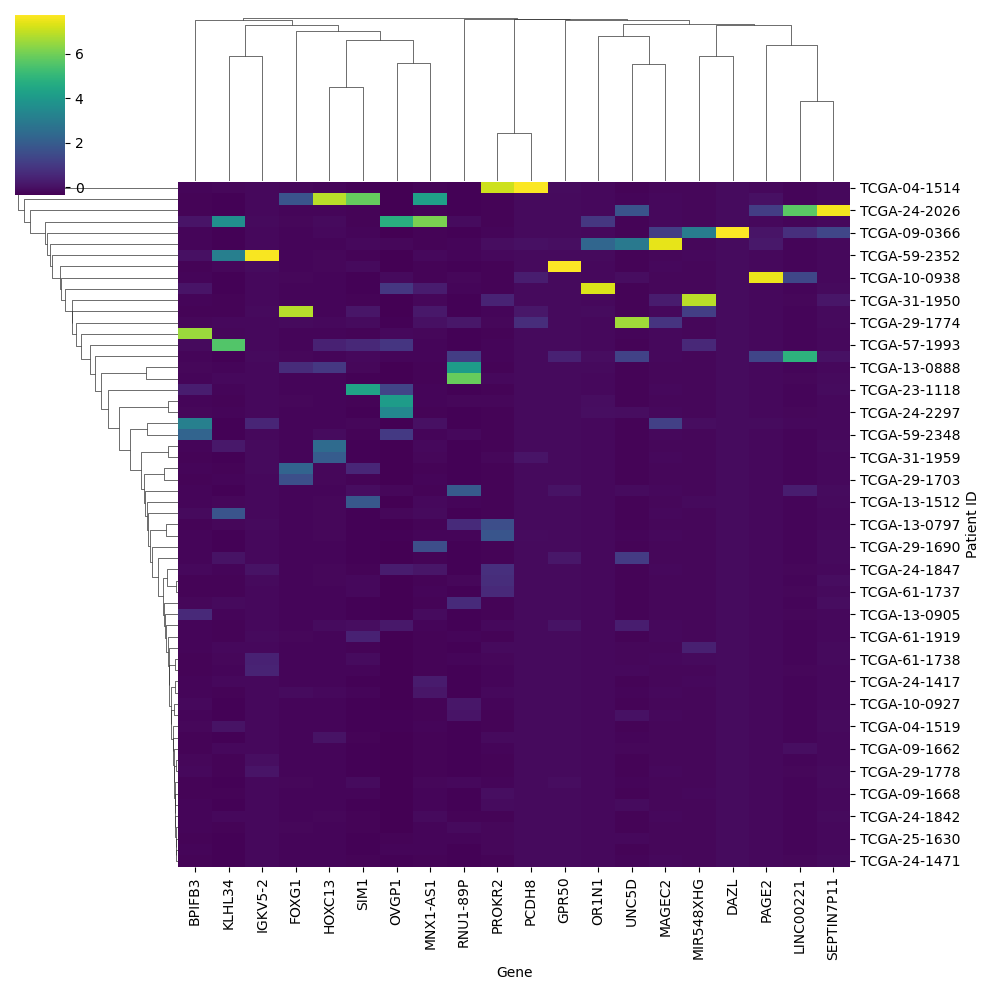

In [206]:
sns.clustermap(toheat, cmap='viridis')
plt.show()


In [208]:
toheat_scaled = toheat.apply(zscore, axis=1)

toheat_scaled = toheat_scaled.fillna(0)

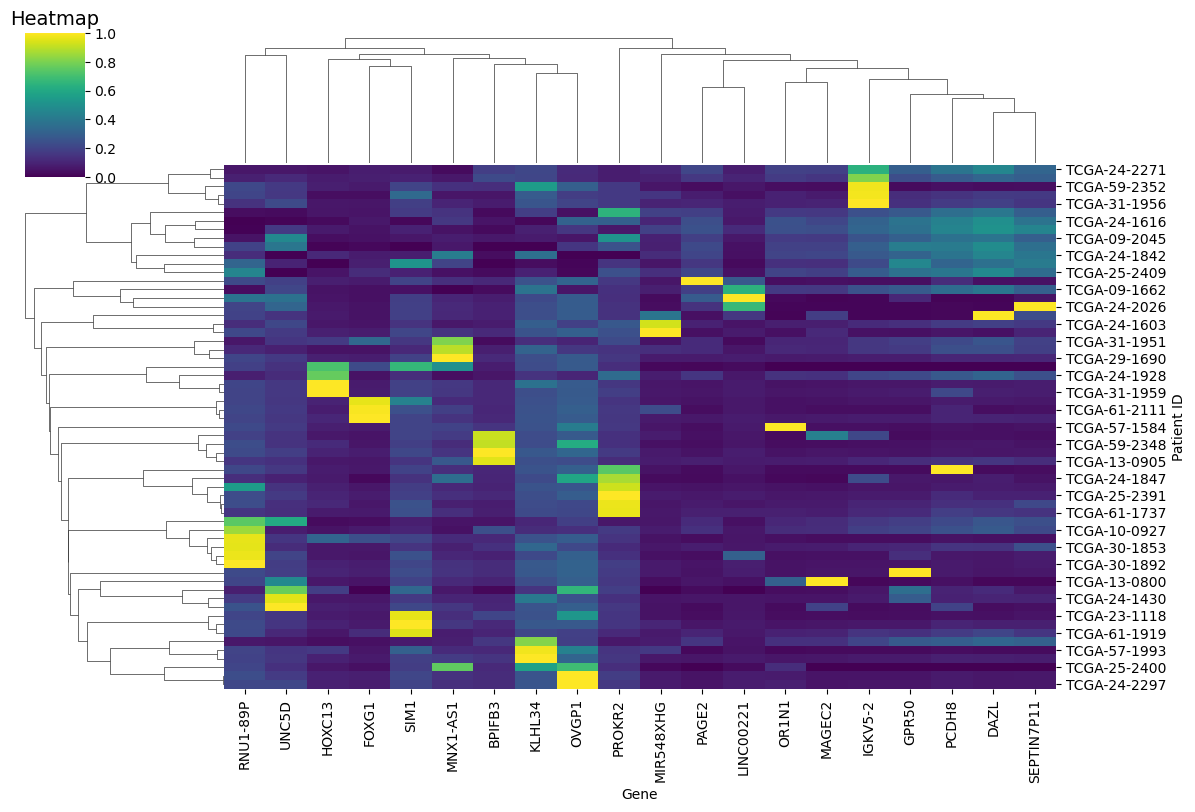

In [212]:
sns.clustermap(
    toheat_scaled,  
    cmap="viridis",  
    metric="correlation",  
    method="average",  
    standard_scale=1,  
    figsize=(12, 8)
)

plt.title("Heatmap", fontsize=14)
plt.savefig("heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# Multifactor Analysis

In [640]:
print(filtered_dfs_combined.columns)

Index([          'Other Patient ID', 'Patient Primary Tumor Site',
                     'Disease Type',               'Project Name',
               'Project Identifier',                        'Sex',
                    'Race Category',         'Ethnicity Category',
           'Patient's Vital Status',              'Year of Death',
       ...
                               9989,                          999,
                               9990,                         9991,
                               9992,                         9993,
                               9994,                         9995,
                               9997,          'DFS_STATUS_BINARY'],
      dtype='object', length=40821)


In [642]:
if "FIGO Stage" in filtered_dfs_combined.columns:
    print("'FIGO Stage' is present in filtered1.")
else:
    print("'FIGO Stage' is NOT present in filtered1.")

'FIGO Stage' is present in filtered1.


In [644]:
filtered_dfs_combined["FIGO Stage"] = filtered_dfs_combined["FIGO Stage"].astype("category")
filtered_dfs_combined["DFS_STATUS_BINARY"] = filtered_dfs_combined["DFS_STATUS_BINARY"].astype("category")

In [646]:
filtered_dfs_combined['DFS_status_str'] = filtered_dfs_combined['DFS_STATUS_BINARY'].map({0: 'No Recurrence', 1: 'Recurrence'}).astype('category')

print(filtered_dfs_combined[['DFS_STATUS_BINARY', 'DFS_status_str']].head()) 

             DFS_STATUS_BINARY DFS_status_str
Patient ID                                   
TCGA-04-1519               1.0     Recurrence
TCGA-13-0888               1.0     Recurrence
TCGA-13-0897               1.0     Recurrence
TCGA-13-1512               1.0     Recurrence
TCGA-20-0987               1.0     Recurrence


In [648]:
filtered_dfs_combined.columns = filtered_dfs_combined.columns.str.replace(" ", "_")

In [650]:
dds = DeseqDataSet(
    counts=expr_filt_T,
    metadata= filtered_dfs_combined[['FIGO_Stage', 'DFS_status_str']],
    design_factors=["FIGO_Stage", "DFS_status_str"],  #differential expression on genotype adjusted for stage
    refit_cooks=True,
    inference=inference,
)

/Applications/anaconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_44313/1167503887.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [652]:
dds.deseq2()

Fitting size factors...
... done in 0.08 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.99 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 3.54 seconds.

Fitting LFCs...
... done in 2.20 seconds.

Calculating cook's distance...
... done in 0.13 seconds.

Replacing 1870 outlier genes.

Fitting dispersions...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 0.19 seconds.

Fitting LFCs...
... done in 0.16 seconds.



In [654]:
print(dds.varm["LFC"])

       Intercept  FIGO_Stage[T.Stage IV]  DFS_status_str[T.Recurrence]
Gene                                                                  
1       1.923595               -0.014558                      0.676969
10      2.073472                0.595670                     -0.376731
100     6.147410               -0.065779                      0.380463
1000    8.906743               -0.970067                     -0.063807
10000   6.971998               -0.331948                     -0.353413
...          ...                     ...                           ...
9992    0.050363               -0.124724                     -0.048269
9993    8.808990                0.127011                     -0.044992
9994    6.820350               -0.183722                     -0.139153
9995    0.644357               -1.405339                     -0.445874
9997    3.160807               -0.115852                     -0.053125

[40796 rows x 3 columns]


In [656]:
stat_res2 = DeseqStats(dds, contrast=["DFS_status_str", "Recurrence", "No Recurrence"], inference=inference)
stat_res2.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: DFS_status_str Recurrence vs No Recurrence
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene                                                                      
1         9.775635        0.976660  0.284709  3.430379  0.000603  0.059631
10        7.967465       -0.543508  0.592596 -0.917165  0.359056  0.762066
100     561.382418        0.548892  0.190427  2.882422  0.003946  0.131429
1000   6438.746795       -0.092054  0.500998 -0.183741  0.854216  0.962812
10000   875.369756       -0.509867  0.346426 -1.471793  0.141077  0.550725
...            ...             ...       ...       ...       ...       ...
9992      0.969380       -0.069637  0.523751 -0.132958  0.894227       NaN
9993   6705.504461       -0.064909  0.147894 -0.438890  0.660741  0.905061
9994    837.341513       -0.200756  0.161174 -1.245580  0.212919  0.638939
9995      1.390899       -0.643260  0.588969 -1.092181  0.274754       NaN
9997     22.598567 

... done in 1.17 seconds.



In [658]:
resdf2 = stat_res2.results_df.reset_index()
resdf2

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,1,9.775635,0.976660,0.284709,3.430379,0.000603,0.059631
1,10,7.967465,-0.543508,0.592596,-0.917165,0.359056,0.762066
2,100,561.382418,0.548892,0.190427,2.882422,0.003946,0.131429
3,1000,6438.746795,-0.092054,0.500998,-0.183741,0.854216,0.962812
4,10000,875.369756,-0.509867,0.346426,-1.471793,0.141077,0.550725
...,...,...,...,...,...,...,...
40791,9992,0.969380,-0.069637,0.523751,-0.132958,0.894227,NaN
40792,9993,6705.504461,-0.064909,0.147894,-0.438890,0.660741,0.905061
40793,9994,837.341513,-0.200756,0.161174,-1.245580,0.212919,0.638939
40794,9995,1.390899,-0.643260,0.588969,-1.092181,0.274754,NaN


In [660]:
resdf2.loc[resdf2.padj<0.05].sort_values("padj")

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
25011,359710,236.454830,4.923589,0.677695,7.265196,3.724978e-13,9.093416e-09
28795,5016,3841.707015,4.132974,0.603526,6.848043,7.486708e-12,9.138276e-08
21977,277,77.724880,3.259782,0.524531,6.214662,5.143517e-10,4.185451e-06
16761,128674,55.250590,-3.860425,0.633704,-6.091845,1.116168e-09,6.811975e-06
24712,346689,437.263546,2.364670,0.399780,5.914926,3.320248e-09,1.621078e-05
...,...,...,...,...,...,...,...
32084,57758,326.922854,1.220011,0.345508,3.531066,4.138890e-04,4.909215e-02
2365,100271722,225.159539,-0.890214,0.251723,-3.536483,4.054927e-04,4.909215e-02
34134,64764,4489.303854,0.635470,0.179978,3.530827,4.142628e-04,4.909215e-02
8100,101929243,245.743083,-0.823324,0.233164,-3.531094,4.138443e-04,4.909215e-02


# Volcano Plot

In [663]:
def Plot_volcano(toplot, xname, yname, nlabel):

    fig,ax=plt.subplots(figsize=(6,6))

    sns.scatterplot(data=toplot, x=xname, y=yname)

    tolabel = toplot.sort_values(yname, ascending=False).head(nlabel)
    for k,row in tolabel.iterrows():
        plt.text(row[xname], row[yname], row['Gene'])

    plt.title("Differential Expression Recurrence vs No Recurrence")
    plt.axhline(-np.log10(0.05), linestyle="--", color="black")
    sns.despine()
    plt.show()

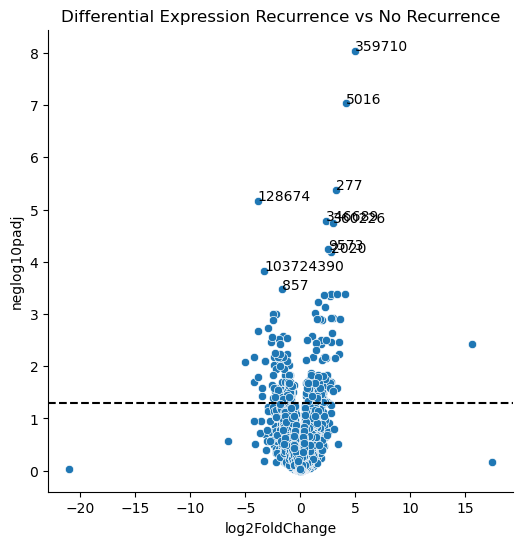

In [665]:
resdf2['neglog10padj'] = -np.log10(resdf2.padj)
Plot_volcano(resdf2, 'log2FoldChange', 'neglog10padj', nlabel=10)

In [667]:
print(resdf2.head())

    Gene     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj  \
0      1     9.775635        0.976660  0.284709  3.430379  0.000603  0.059631   
1     10     7.967465       -0.543508  0.592596 -0.917165  0.359056  0.762066   
2    100   561.382418        0.548892  0.190427  2.882422  0.003946  0.131429   
3   1000  6438.746795       -0.092054  0.500998 -0.183741  0.854216  0.962812   
4  10000   875.369756       -0.509867  0.346426 -1.471793  0.141077  0.550725   

   neglog10padj  
0      1.224529  
1      0.118007  
2      0.881310  
3      0.016459  
4      0.259065  


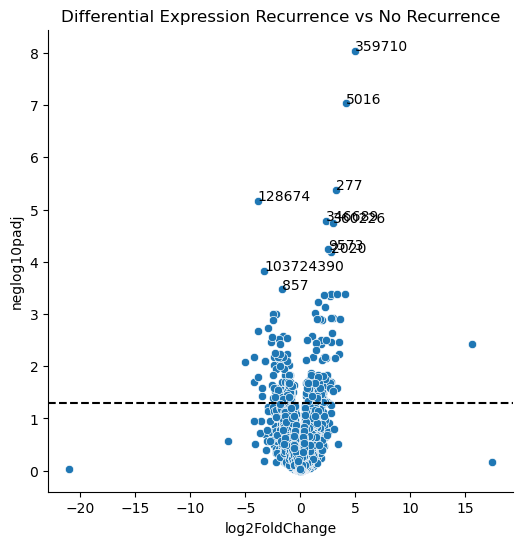

In [669]:
resdf2['neglog10padj'] = -np.log10(resdf2.padj)
Plot_volcano(resdf2, 'log2FoldChange', 'neglog10padj', nlabel=10)

In [671]:
resdf2.head()

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
0,1,9.775635,0.976660,0.284709,3.430379,0.000603,0.059631,1.224529
1,10,7.967465,-0.543508,0.592596,-0.917165,0.359056,0.762066,0.118007
2,100,561.382418,0.548892,0.190427,2.882422,0.003946,0.131429,0.881310
3,1000,6438.746795,-0.092054,0.500998,-0.183741,0.854216,0.962812,0.016459
4,10000,875.369756,-0.509867,0.346426,-1.471793,0.141077,0.550725,0.259065


In [673]:
top_genes_with_second_column = resdf2.sort_values('padj').head(10).iloc[:, [resdf2.columns.get_loc('Gene'), 1]]
print(top_genes_with_second_column.iloc[:, [resdf2.columns.get_loc('Gene'), 1]])

            Gene     baseMean
25011     359710   236.454830
28795       5016  3841.707015
21977        277    77.724880
16761     128674    55.250590
24712     346689   437.263546
25130     360226     5.666847
40388       9573    23.691193
19171       2020    31.733237
9220   103724390    18.590643
39043        857  3089.323603


In [675]:
# Extract the top 10 genes with the lowest p_adj
top_genes = resdf2.sort_values('padj').head(10)['Gene'].tolist()

print(top_genes)

['359710', '5016', '277', '128674', '346689', '360226', '9573', '2020', '103724390', '857']


In [677]:
!pip install mygene

In [679]:
mg = mygene.MyGeneInfo()

top_gene_ids = resdf2.sort_values('padj').head(10)['Gene'].tolist()

gene_info = mg.querymany(top_gene_ids, scopes="entrezgene", fields="symbol", species="human")

gene_symbols = [entry.get('symbol', entry['query']) for entry in gene_info]

print(gene_symbols)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


['BPIFB3', 'OVGP1', 'AMY1B', 'PROKR2', 'KLRG2', 'PRSS41', 'GDF3', 'EN2', 'LINC01287', 'CAV1']


In [681]:
mg = mygene.MyGeneInfo()

gene_ids = resdf2['Gene'].unique().tolist()

gene_info = mg.querymany(gene_ids, scopes="entrezgene", fields="symbol", species="human")

gene_dict = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

resdf2['Gene'] = resdf2['Gene'].map(gene_dict)

resdf2.to_csv("resdf2_with_symbols_DFS.csv", index=False)

print("resdf2 saved with gene symbols as 'resdf2_with_symbols_DFS.csv'")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874233', '100874266', '100874283', '100874340', '1009963


resdf2 saved with gene symbols as 'resdf2_with_symbols_DFS.csv'


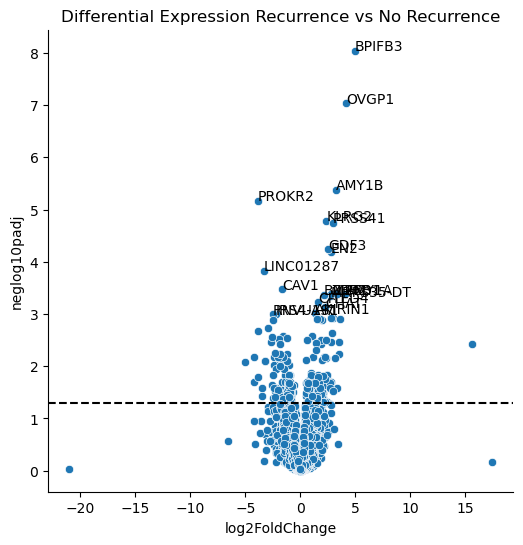

In [683]:
gene_map = {
    5016: "OVGP1",
    1360: "CPB1",
    91156: "IGFN1",
    101927700: "LINC01524",
    23217: "ZFR2",
    28834: "IGLC7",
    2020: "EN2",
    5005: "ORM2",
    154790: "CLEC2L",
    257240: "KLHL34",
    138009: "DCAF4L2"
}

resdf2["Gene_Name"] = resdf2["Gene"].map(gene_map)

resdf2["Gene_Name"] = resdf2["Gene_Name"].fillna(resdf2["Gene"].astype(str))

resdf2 = resdf2.set_index("Gene_Name")  
resdf2["label"] = resdf2.index  

Plot_volcano(resdf2, 'log2FoldChange', 'neglog10padj', nlabel=20)

## Figure out what is up and down regulated 

In [686]:
# Extract top 10 genes with lowest p_adj
top_genes = resdf2.sort_values('padj').head(20)[['Gene', 'log2FoldChange']]

# Upregulated: log2FC > 0
upregulated_genes = top_genes[top_genes['log2FoldChange'] > 0]

# Downregulated: log2FC < 0
downregulated_genes = top_genes[top_genes['log2FoldChange'] < 0]

print("Upregulated Genes:\n", upregulated_genes)
print("\nDownregulated Genes:\n", downregulated_genes)

Upregulated Genes:
                 Gene  log2FoldChange
Gene_Name                           
BPIFB3        BPIFB3        4.923589
OVGP1          OVGP1        4.132974
AMY1B          AMY1B        3.259782
KLRG2          KLRG2        2.364670
PRSS41        PRSS41        2.930173
GDF3            GDF3        2.504790
EN2              EN2        2.756874
AMY1A          AMY1A        4.061419
L1TD1          L1TD1        3.289074
ZFR2            ZFR2        2.790482
BMP8B          BMP8B        2.121647
MRPS35-DT  MRPS35-DT        2.721275
CITED4        CITED4        1.641057
CHAT            CHAT        2.278752
AKIRIN1      AKIRIN1        1.328747

Downregulated Genes:
                 Gene  log2FoldChange
Gene_Name                           
PROKR2        PROKR2       -3.860425
LINC01287  LINC01287       -3.296504
CAV1            CAV1       -1.669838
RNVU1-7      RNVU1-7       -2.484647
IRS4-AS1    IRS4-AS1       -2.235943


# ScRNA Analysis 

In [689]:
genes_of_interest = [
    "WFDC2", "KRT8", "EPCAM", "CD24", "LEFTY1", "RPL3", "ANXA4", "GSTP1", "CXCL1",
    "SPP1", "S100A6", "SPARC", "COL1A2", "COL3A1", "FN1", "FAP", "ACTA2", "SERPINE1",
    "HMGB2", "MKI67", "CENPF", "UBE2C", "CD74", "HLA-B", "SRGN", "CD14", "LYZ",
    "PTPRC", "CD163", "CD86", "CD3D", "CD3G", "CD8A", "XCL1", "LAMP3", "MS4A1", "CD27"
]


resdf["Gene"] = resdf["Gene"].astype(str)

genes_found = resdf[resdf["Gene"].isin(genes_of_interest)]

print("\nGenes Found in Dataset:")
print(genes_found.head(37))  

genes_found.to_csv("genes_found_in_dataset.csv", index=False)

display(genes_found)


Genes Found in Dataset:
           Gene       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
1531       CD24   87502.219119       -0.472466  0.310535 -1.521459  0.128145   
9264      WFDC2   88757.782571       -0.023255  0.313935 -0.074077  0.940949   
10535     CENPF    3418.636171        0.158447  0.227386  0.696821  0.485915   
10543    LEFTY1      18.126247        0.255225  0.411898  0.619631  0.535501   
14698     UBE2C    4747.772100        0.023657  0.262460  0.090135  0.928180   
16652    COL1A2   93049.651922       -0.041202  0.347353 -0.118617  0.905579   
16672    COL3A1   68142.563788       -0.264249  0.410893 -0.643108  0.520154   
19391       FAP     492.090409       -0.269383  0.512336 -0.525793  0.599032   
20227       FN1   69649.765546       -0.549721  0.414439 -1.326422  0.184700   
21756     LAMP3    1882.473845        0.562004  0.353837  1.588311  0.112216   
23462     CXCL1    1152.851321       -0.899865  0.507332 -1.773722  0.076109   
23488     GSTP1

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
1531,CD24,87502.219119,-0.472466,0.310535,-1.521459,0.128145,0.580365,0.236299
9264,WFDC2,88757.782571,-0.023255,0.313935,-0.074077,0.940949,0.988645,0.004960
10535,CENPF,3418.636171,0.158447,0.227386,0.696821,0.485915,0.857500,0.066766
10543,LEFTY1,18.126247,0.255225,0.411898,0.619631,0.535501,0.874173,0.058402
14698,UBE2C,4747.772100,0.023657,0.262460,0.090135,0.928180,0.985620,0.006291
16652,COL1A2,93049.651922,-0.041202,0.347353,-0.118617,0.905579,0.980874,0.008387
16672,COL3A1,68142.563788,-0.264249,0.410893,-0.643108,0.520154,0.870798,0.060083
19391,FAP,492.090409,-0.269383,0.512336,-0.525793,0.599032,0.898746,0.046363
20227,FN1,69649.765546,-0.549721,0.414439,-1.326422,0.184700,0.654233,0.184267
21756,LAMP3,1882.473845,0.562004,0.353837,1.588311,0.112216,0.554259,0.256287


In [691]:
if "Gene" not in resdf.columns:
    raise KeyError("The column 'Gene' was not found in the bulk RNA-seq dataset.")

required_cols = ["log2FoldChange", "pvalue"]
missing_cols = [col for col in required_cols if col not in resdf.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in bulk RNA-seq dataset: {missing_cols}")

logfc_threshold = 1  
pval_threshold = 0.05 

bulk_filtered = resdf[resdf["Gene"].isin(genes_of_interest)].copy()

bulk_filtered["Regulation"] = bulk_filtered.apply(
    lambda row: "Upregulated" if row["log2FoldChange"] > logfc_threshold and row["pvalue"] < pval_threshold else
                "Downregulated" if row["log2FoldChange"] < -logfc_threshold and row["pvalue"] < pval_threshold else
                "Not Significant", axis=1
)

print("\nBulk RNA-seq Expression of scRNA Genes:")
print(bulk_filtered[["Gene", "log2FoldChange", "pvalue", "Regulation"]].head())  

bulk_filtered.to_csv("bulk_rnaseq_scRNA_filtered.csv", index=False)

display(bulk_filtered)


Bulk RNA-seq Expression of scRNA Genes:
         Gene  log2FoldChange    pvalue       Regulation
1531     CD24       -0.472466  0.128145  Not Significant
9264    WFDC2       -0.023255  0.940949  Not Significant
10535   CENPF        0.158447  0.485915  Not Significant
10543  LEFTY1        0.255225  0.535501  Not Significant
14698   UBE2C        0.023657  0.928180  Not Significant


,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,Regulation
1531,CD24,87502.219119,-0.472466,0.310535,-1.521459,0.128145,0.580365,0.236299,Not Significant
9264,WFDC2,88757.782571,-0.023255,0.313935,-0.074077,0.940949,0.988645,0.004960,Not Significant
10535,CENPF,3418.636171,0.158447,0.227386,0.696821,0.485915,0.857500,0.066766,Not Significant
10543,LEFTY1,18.126247,0.255225,0.411898,0.619631,0.535501,0.874173,0.058402,Not Significant
14698,UBE2C,4747.772100,0.023657,0.262460,0.090135,0.928180,0.985620,0.006291,Not Significant
16652,COL1A2,93049.651922,-0.041202,0.347353,-0.118617,0.905579,0.980874,0.008387,Not Significant
16672,COL3A1,68142.563788,-0.264249,0.410893,-0.643108,0.520154,0.870798,0.060083,Not Significant
19391,FAP,492.090409,-0.269383,0.512336,-0.525793,0.599032,0.898746,0.046363,Not Significant
20227,FN1,69649.765546,-0.549721,0.414439,-1.326422,0.184700,0.654233,0.184267,Not Significant
21756,LAMP3,1882.473845,0.562004,0.353837,1.588311,0.112216,0.554259,0.256287,Not Significant


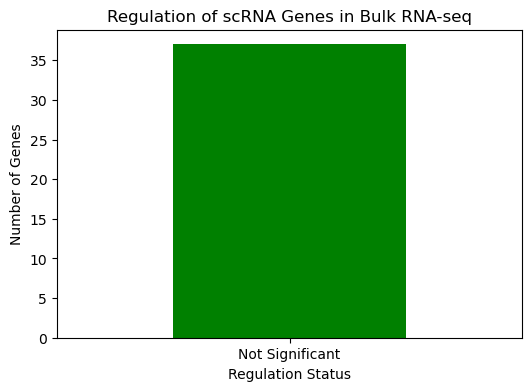

In [693]:
regulation_counts = bulk_filtered["Regulation"].value_counts()

plt.figure(figsize=(6, 4))
regulation_counts.plot(kind="bar", color=["green", "red", "gray"])
plt.xlabel("Regulation Status")
plt.ylabel("Number of Genes")
plt.title("Regulation of scRNA Genes in Bulk RNA-seq")
plt.xticks(rotation=0)
plt.show()

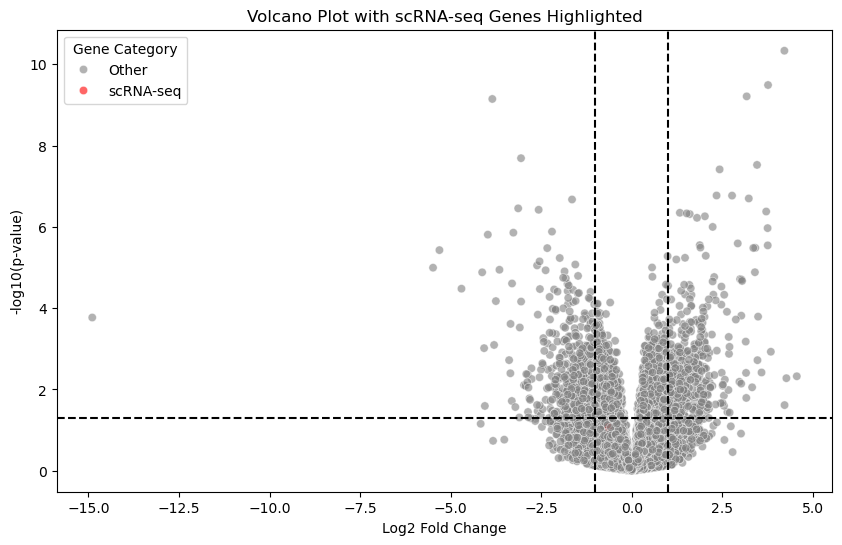

In [695]:
resdf["highlight"] = resdf["Gene"].apply(lambda x: "scRNA-seq" if x in genes_of_interest else "Other")

logfc_threshold = 1  
pval_threshold = 0.05

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=resdf, x="log2FoldChange", y=-np.log10(resdf["pvalue"]),
    hue="highlight", palette={"scRNA-seq": "red", "Other": "gray"}, alpha=0.6
)

plt.axvline(x=logfc_threshold, linestyle="--", color="black")
plt.axvline(x=-logfc_threshold, linestyle="--", color="black")
plt.axhline(y=-np.log10(pval_threshold), linestyle="--", color="black")

for _, row in resdf[(resdf["highlight"] == "scRNA-seq") & (resdf["pvalue"] < pval_threshold)].iterrows():
    plt.text(row["log2FoldChange"], -np.log10(row["pvalue"]), row["Gene"],
             fontsize=8, ha='right', color='black', alpha=0.7)

plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot with scRNA-seq Genes Highlighted")
plt.legend(title="Gene Category")
plt.show()



# ECM proteins

In [698]:
genes_of_interest = [
    "COL1A2", "COL4A1", "COL1A1", "SPARC", "VIM"
]

resdf["Gene"] = resdf["Gene"].astype(str)

genes_found = resdf[resdf["Gene"].isin(genes_of_interest)]

print("\nGenes Found in Dataset:")
print(genes_found.head(10))  

genes_found.to_csv("genes_found_in_dataset.csv", index=False)

display(genes_found)


Genes Found in Dataset:
         Gene       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
16645  COL1A1  202542.629959       -0.046870  0.376728 -0.124414  0.900987   
16652  COL1A2   93049.651922       -0.041202  0.347353 -0.118617  0.905579   
16688  COL4A1   12405.187638       -0.064041  0.233716 -0.274011  0.784076   
34784   SPARC   63530.851019       -0.168474  0.329068 -0.511973  0.608670   
36363     VIM   26462.358194       -0.107410  0.243354 -0.441373  0.658943   

           padj  neglog10padj  highlight  
16645  0.979913      0.008812      Other  
16652  0.980874      0.008387  scRNA-seq  
16688  0.955809      0.019629      Other  
34784  0.902436      0.044584  scRNA-seq  
36363  0.918208      0.037059      Other  


,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,highlight
16645,COL1A1,202542.629959,-0.046870,0.376728,-0.124414,0.900987,0.979913,0.008812,Other
16652,COL1A2,93049.651922,-0.041202,0.347353,-0.118617,0.905579,0.980874,0.008387,scRNA-seq
16688,COL4A1,12405.187638,-0.064041,0.233716,-0.274011,0.784076,0.955809,0.019629,Other
34784,SPARC,63530.851019,-0.168474,0.329068,-0.511973,0.608670,0.902436,0.044584,scRNA-seq
36363,VIM,26462.358194,-0.107410,0.243354,-0.441373,0.658943,0.918208,0.037059,Other


# stemness

In [701]:
genes_of_interest = ["ALDH1", "ABCG2", "CXCR4", "CD133", "NANOG", "NOTCH3", "C-KIT", "PAX8", "SOX2", "OCT4", "FOXK2", "L1CAM"]

filtered_resdf = resdf[resdf['Gene'].isin(genes_of_interest)]
filtered_resdf

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,highlight
25136,FOXK2,5182.970502,0.174148,0.152086,1.145063,0.252183,0.720997,0.142066,Other
25973,L1CAM,3544.513345,0.868187,0.355109,2.444848,0.014491,0.273624,0.562846,Other
28606,NOTCH3,18631.524020,0.046903,0.270692,0.173269,0.862440,0.971741,0.012450,Other
34763,SOX2,210.399354,2.086401,0.633321,3.294380,0.000986,0.089706,1.047178,Other
36702,PAX8,22344.611483,0.129601,0.206281,0.628275,0.529824,0.872892,0.059039,Other
36706,CXCR4,7756.087865,0.460013,0.269400,1.707547,0.087720,0.509746,0.292646,Other
37281,NANOG,10.088979,1.527854,0.397013,3.848371,0.000119,0.029311,1.532969,Other
40251,ABCG2,164.652301,0.170136,0.224738,0.757044,0.449023,0.841062,0.075172,Other
